RNN(Recurrent Neural Network)
===
시퀀스 배열로 다루는 순환 신경망
---
### 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기
* 인터넷 영화 데이터베이스(IMDb)에 있는 영화에 대한 긍정, 부정 평가를 활용해 분석 수행.
* 데이터 전처리 과정은 로이터 뉴스 데이터와 거의 같음.
* 다만 클래스가 긍정 또는 부정 두 가지뿐이라 원-핫 인코딩 과정이 없음.
#### 1. 데이터의 전처리와 모델 설정

In [69]:
# 라이브러리 로드
from tensorflow.keras.datasets.imdb import load_data
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 자동완성용
from keras.datasets.imdb import load_data
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Activation
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

In [70]:
# seed 값 설정
np.random.seed(0)
tf.random.set_seed(0)

# 학습셋과 테스트셋 지정
(X_train, y_train), (X_test, y_test) = load_data(num_words=5000)

# 데이터 전처리 / maxlen : 길이 맞춰주는 역할
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

* 모델을 다음과 같이 설정
* 마지막에 model.summary() 함수를 넣으면 현재 설정된 모델의 구조를 한 눈에 볼 수 있음.

In [71]:
# 모델의 설정
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
# strides : 컨볼루션 커널 이동 간격 / 보폭
model.add(Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
# 새로운 방식
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 55)                26400     
                                                                 
 dense_1 (Dense)             (None, 1)                 56        
                                                      

#### 2. 1차원 문자열 데이터와 2차원 이미지의 차이
* 앞서 Conv2D와 MaxPooling2D는 앞서 MNIST 손글씨 인식에서 2차원 배열의 이미지를 다루기 위해 사용함.
* 하지만 현재 데이터는 1차원의 문자열 데이터이기 때문에 Conv1D와 MaxPooling1D로 1차원 이동하는 컨볼루션 방식 사용.
* 1차원 컨볼루션 예시(kernel_size=3, stride=1) : 
$$\begin{bmatrix}1&4&3&2\end{bmatrix}\qquad\cdots(input\ data)$$
$$\begin{bmatrix}\times1&\times0&\times1\end{bmatrix}\qquad\cdots(mask\ or\ kernel)$$
$$1\times1+4\times0+3\times1 = 1+3=4$$
$$4\times1+3\times0+2\times1 = 4+2=6$$
$$\begin{bmatrix}4&6\end{bmatrix}\qquad\cdots(output\ data)$$
* MaxPooling1D 역시 1차원 배열상의 정해진 구간에서 가장 큰 값을 다음 층으로 넘기고 나머지는 버림.
* 1차원 MaxPooling 예시 (pool_size=2) :
$$\begin{bmatrix}1&4&3&2\end{bmatrix}\qquad\cdots(input\ data)$$
$$\begin{bmatrix}1&4\end{bmatrix}\quad\begin{bmatrix}3&2\end{bmatrix}\qquad\cdots(pool\ apply)$$
$$\begin{bmatrix}4&3\end{bmatrix}\qquad\cdots(output\ data)$$
#### 3. 모델 실행

* 번외 : 텐서보드 사용
    * os 모듈: 운영 체제와 상호 작용을 할 때, 사용하는 Python 기본 모듈로, Python 안에서 끝내는 것이 아닌 자신의 컴퓨터와 어떠한 작업을 하고자 한다면, 해당 모듈을 필수로 사용하게 된다.
    * os.curdir: 현재 디렉터리를 가지고 온다.
    * os.path.join('C:\Tmp', 'a', 'b'): 주어진 경로들을 합쳐서 하나로 만든다. 
    *   dir_name은 Tensorboard가 바라 볼 디렉터리의 이름이다.
    * 코드 실행 시, 생성된 로그 데이터가 섞이지 않도록, dir_name 디렉터리 아래에 현재 날짜와 시간으로 하위 디렉터리의 경로를 만들어낸다.  

In [72]:
import os
import datetime

# Log data를 저장할 디렉터리 이름 설정
dir_name = "Learning_log"

# main 디렉터리와 sub 디렉터리 생성 함수
def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name)
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, sub_dir_name)

In [73]:
# 콜백함수 - 텐서보드
TB_log_dir = make_Tensorboard_dir(dir_name)
TensorB = TensorBoard(log_dir = TB_log_dir)

# 모델 저장 조건 설정
model_dir_name = "model"

def make_Model_dir(model_dir_name):
    root_logdir = os.path.join(os.curdir, model_dir_name)
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    folder_dir = os.path.join(root_logdir, sub_dir_name)
    file_name = "{epoch:02d}_{val_loss:.4f}.hdf5"
    return os.path.join(folder_dir, file_name)

checkpointer = ModelCheckpoint(filepath=make_Model_dir(model_dir_name), monitor="val_loss", verbose=1, save_best_only=True)

# 콜백함수 - 얼리스탑
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5)

# 모델의 컴파일
model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])


# 모델의 실행
history = model.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping_callback, TensorB, checkpointer])

# 테스트 정확도 출력
print(f"\n Test Accuracy:{model.evaluate(X_test,y_test)[1]:.4f}")

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7648
Epoch 1: val_loss improved from inf to 0.33133, saving model to .\model\20220512-140010\01_0.3313.hdf5
250/250 [==============================] - 11s 41ms/step - loss: 0.4557 - accuracy: 0.7648 - val_loss: 0.3313 - val_accuracy: 0.8533
Epoch 2/20
249/250 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.8773
Epoch 2: val_loss improved from 0.33133 to 0.32408, saving model to .\model\20220512-140010\02_0.3241.hdf5
250/250 [==============================] - 11s 44ms/step - loss: 0.2915 - accuracy: 0.8772 - val_loss: 0.3241 - val_accuracy: 0.8583
Epoch 3/20
249/250 [============================>.] - ETA: 0s - loss: 0.2478 - accuracy: 0.9000
Epoch 3: val_loss did not improve from 0.32408
250/250 [==============================] - 11s 44ms/step - loss: 0.2478 - accuracy: 0.9000 - val_loss: 0.3461 - val_accuracy: 0.8534
Epoch 4/20
249/250 [============================>.] - ET

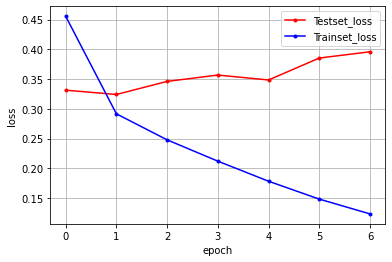

In [74]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### 4. 토큰화 이전의 IMDb 데이터를 활용한 실습

In [75]:
# 데이터 불러오기
origin = pd.read_csv("./csv_data/IMDB Dataset.csv")
origin.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [76]:
# html 줄바꿈 삭제
review = origin.review.str.replace("<br />", "")
sentiment = origin.sentiment

In [77]:
# 확인
review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. The filming tec...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [102]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
label = lb.fit_transform(sentiment)

In [78]:
# 스탑워드 라이브러리
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import re

In [79]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [81]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [82]:
def preprocess(review, stem=stemmer):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(review).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [83]:
review_pr = review.apply(preprocess)

In [84]:
review_pr

0        one review mention watch 1 oz episod hook righ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic famili littl boy jake think zombi closet...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job creativ origin fir...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    go disagre previous comment side maltin one se...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [90]:
# 토큰화 및 전처리 라이브러리
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

# 자동완성
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import load_model

In [86]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_pr)

In [87]:
review_tk = tokenizer.texts_to_sequences(review_pr)

In [88]:
review_test = sequence.pad_sequences(review_tk, maxlen=100)

In [89]:
review_test

array([[ 440, 3314, 1893, ...,  450, 3399,  368],
       [   0,    0,    0, ...,  278,   16,  143],
       [   0,    0,    0, ...,   26,    9,  116],
       ...,
       [3628, 1563,  120, ...,  430, 3254, 1056],
       [   0,    0,    0, ..., 1803, 1416,  334],
       [   0,    0,    0, ...,  920,  574,    1]])

In [91]:
model_t = load_model("./model/20220512-140010/02_0.3241.hdf5")

In [96]:
pred = model_t.predict(review_test)

In [104]:
pred

array([[0.18281749],
       [0.7458974 ],
       [0.19429493],
       ...,
       [0.03277937],
       [0.11630675],
       [0.7675109 ]], dtype=float32)

In [105]:
label

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [106]:
from sklearn.metrics import accuracy_score

In [108]:
accuracy_score(label, pred.round())

0.51526